In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 as cv
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Use this to flag whether to work with the custom dataset or PyTorch's dataset.
CUSTOM_DATASET_FLAG = False

cuda


## Local Dataset Creation

The next three cells are used to create a custom PyTorch dataset using the manually downloaded MNIST dataset. This is a useful showcase on how to create a custom dataset class using PyTorch concepts in the form of DataLoaders and transforms. However, if training using Colab, this may not be useful since the files need to be uploaded to the directory. Moreover, PyTorch already has the MNIST dataset under torchvision's datasets subclass.

### Dataset Inspection

In [3]:
if CUSTOM_DATASET_FLAG:
  training_data_folders = os.listdir("dataset/training")
  test_data_folders = os.listdir("dataset/testing")
  training_data_count = []
  test_data_count = []

  for folder in training_data_folders:
      folder_count = len(os.listdir(f"dataset/training/{folder}"))
      training_data_count.append(folder_count)

  for folder in test_data_folders:
      folder_count = len(os.listdir(f"dataset/testing/{folder}"))
      test_data_count.append(folder_count)

  figure = plt.figure(figsize=(10,10))

  plt.subplot(2,1,1)
  plt.title("Training Data Summary")
  plt.bar(training_data_folders, training_data_count)

  plt.subplot(2,1,2)
  plt.title("Test Data Summary")
  plt.bar(test_data_folders, test_data_count)

  plt.show()

  print(f"Total Training Data: {sum(training_data_count)}")
  print(f"Total Test Data: {sum(test_data_count)}")

### Data Loading

In [4]:
if CUSTOM_DATASET_FLAG:
  data = []

  for folder in training_data_folders:
      image_list = os.listdir(f"dataset/training/{folder}")
      for image in image_list:
          temp_arr = [image, folder, "train"]
          data.append(temp_arr)

  for folder in test_data_folders:
      image_list = os.listdir(f"dataset/testing/{folder}")
      for image in image_list:
          temp_arr = [image, folder, "test"]
          data.append(temp_arr)

  df = pd.DataFrame(data, columns=["file_name", "label", "data_type"])
  display(df.head())
  display(df.tail())
  df.to_csv("annotations.csv", index=False, header=True)

### Custom PyTorch Dataset Creation

In [5]:
if CUSTOM_DATASET_FLAG:
  class mnistDataset(torch.utils.data.Dataset):
      def __init__(self, root, annotations_file, train=True, transform=None, target_transform=None):
          self.root = root
          self.labels = pd.read_csv(annotations_file)
          self.train = train
          self.transform = transform
          self.target_transform = target_transform

          if self.train:
              self.root = os.path.join(self.root, "training")
              self.labels = self.labels[self.labels["data_type"] == "train"]
          else:
              self.root = os.path.join(self.root, "testing")
              self.labels = self.labels[self.labels["data_type"] == "test"]
      
      def __len__(self):
          return len(self.labels)
      
      def __getitem__(self, index):
          image_path = os.path.join(self.root, str(self.labels.iloc[index, 1]), self.labels.iloc[index, 0])
          image = Image.open(image_path)
          label = self.labels.iloc[index, 1]
          if self.transform:
              image = self.transform(image)
          if self.target_transform:
              label = self.target_transform(label)
          return image, label
          
  composed_transform = transforms.Compose([
      transforms.ToTensor()
  ])

  training_dataset = mnistDataset("dataset", "annotations.csv", train=True, transform=composed_transform, target_transform=None)
  test_dataset = mnistDataset("dataset", "annotations.csv", train=False, transform=composed_transform, target_transform=None)

  train_loader = DataLoader(dataset=training_dataset, batch_size=32)
  test_loader = DataLoader(dataset=test_dataset, batch_size=32)

  print(training_dataset.__getitem__(0))
  print(training_dataset.__len__())

## Dataset Creation with PyTorch Datasets

Since MNIST is already available under PyTorch datasets, this may be the easier way work with this data, either locally or on Colab.

In [6]:
if not CUSTOM_DATASET_FLAG:
  # Add more transforms if necessary, eg. normalization
  composed_transforms = transforms.Compose([transforms.ToTensor()])
  
  data_dir = "data"
  if data_dir not in os.listdir(os.getcwd()):
    os.mkdir(data_dir)

  training_dataset = datasets.MNIST(root=data_dir, download=True, train=True, transform=composed_transforms)
  testing_dataset = datasets.MNIST(root=data_dir, download=True, train=False, transform=composed_transforms)

  train_loader = DataLoader(dataset=training_dataset, batch_size=32, shuffle=True)
  test_loader = DataLoader(dataset=testing_dataset, batch_size=32)

  print(training_dataset.__len__())
  print(testing_dataset.__len__())

60000
10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Model Finetuning

In [7]:
model = models.resnet18(pretrained=False)

# Change the input layer to for a single channel image instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Change the final fully connected layer.
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model Training

In [8]:
def train_loop(epoch, train_loader, model, loss_function, optimizer):
    model.train()

    batch_size = len(train_loader)
    training_size = len(train_loader.dataset)
    training_loss = 0
    correct = 0

    with tqdm(train_loader, position=0, leave=True, unit="batch") as train_batch:
        train_batch.set_description(f"Epoch: {epoch} --------------------")
        for data in train_batch:
            # Compute prediction and loss
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)
            loss = loss_function(predictions, labels)
            training_loss += loss.item()

            _, predicted_labels = predictions.max(1)
            correct += predicted_labels.eq(labels).sum().item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    train_accuracy = correct / training_size
    average_train_loss = training_loss / batch_size

    print(f"Train Loss: {round(average_train_loss, 3)}  |   Train Accuracy: {round(train_accuracy, 3)}")

    return average_train_loss, train_accuracy


def test_loop(epoch, test_loader, model, loss_function):
    model.eval()

    batch_size = len(test_loader)
    test_size = len(test_loader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            test_loss += loss_function(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    average_test_loss = test_loss / batch_size
    test_accuracy = correct / test_size

    print(f"Test Loss: {round(average_test_loss, 3)}    |   Test Accuracy: {round(test_accuracy, 3)}")

    return average_test_loss, test_accuracy

train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

epochs = 5
for epoch in range(1, epochs+1):
    average_train_loss, train_accuracy = train_loop(epoch, train_loader, model, loss_function, optimizer)
    average_test_loss, test_accuracy = test_loop(epoch, test_loader, model, loss_function)

    train_loss_list.append(average_train_loss)
    test_loss_list.append(average_test_loss)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)

Epoch: 1 --------------------:   0%|          | 0/1875 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch: 1 --------------------: 100%|██████████| 1875/1875 [01:27<00:00, 21.43batch/s]


Train Loss: 0.175  |   Train Accuracy: 0.949
Test Loss: 0.158    |   Test Accuracy: 0.956


Epoch: 2 --------------------: 100%|██████████| 1875/1875 [01:28<00:00, 21.28batch/s]


Train Loss: 0.079  |   Train Accuracy: 0.978
Test Loss: 0.055    |   Test Accuracy: 0.986


Epoch: 3 --------------------: 100%|██████████| 1875/1875 [01:27<00:00, 21.31batch/s]


Train Loss: 0.059  |   Train Accuracy: 0.984
Test Loss: 0.037    |   Test Accuracy: 0.989


Epoch: 4 --------------------: 100%|██████████| 1875/1875 [01:27<00:00, 21.39batch/s]


Train Loss: 0.051  |   Train Accuracy: 0.986
Test Loss: 0.037    |   Test Accuracy: 0.989


Epoch: 5 --------------------: 100%|██████████| 1875/1875 [01:28<00:00, 21.29batch/s]


Train Loss: 0.038  |   Train Accuracy: 0.989
Test Loss: 0.03    |   Test Accuracy: 0.992


## Plot Learning Curves

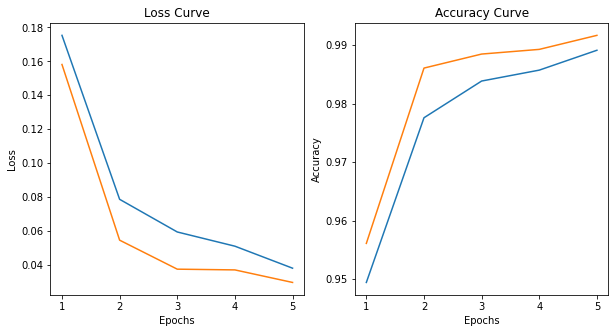

In [9]:
figure = plt.figure(figsize=(10,5))

epoch_axis = [i for i in range(1, epochs + 1)]

plt.subplot(1, 2, 1)
plt.plot(epoch_axis, train_loss_list)
plt.plot(epoch_axis, test_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(epoch_axis, train_accuracy_list)
plt.plot(epoch_axis, test_accuracy_list)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.show()

## Make Batch Predictions and Generate Additional Metrics

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



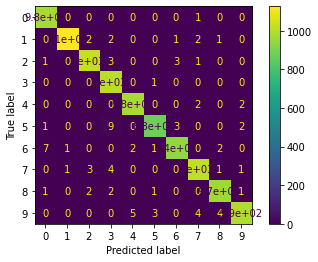

In [10]:
y_true = []
y_pred = []

for _, labels in test_loader:
  y_true.extend(labels.numpy())

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    labels = outputs.argmax(1).cpu().numpy()
    y_pred.extend(labels)

labels = ["0","1","2","3","4","5","6","7","8","9"]
classification_report = classification_report(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)

print(classification_report)
disp.plot()
plt.show()

## Save Model

In [12]:
torch.save(model, "model_091021_v2.pth")